In [1]:
import glob
from PIL import Image
import cv2
import albumentations
import torch
import numpy as np
import io
from torch.utils.data import Dataset
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import csv
train_files = glob.glob('/home/bearbalalaika/Desktop/Kaggle/Flovers/*/train/*.tfrec')
val_files = glob.glob('/home/bearbalalaika/Desktop/Kaggle/Flovers/*/val/*.tfrec')
test_files = glob.glob("/home/bearbalalaika/Desktop/Kaggle/Flovers/*/test/*.tfrec")

In [2]:
print(train_files[:5])

['/home/bearbalalaika/Desktop/Kaggle/Flovers/tfrecords-jpeg-192x192/train/03-192x192-798.tfrec', '/home/bearbalalaika/Desktop/Kaggle/Flovers/tfrecords-jpeg-192x192/train/04-192x192-798.tfrec', '/home/bearbalalaika/Desktop/Kaggle/Flovers/tfrecords-jpeg-192x192/train/01-192x192-798.tfrec', '/home/bearbalalaika/Desktop/Kaggle/Flovers/tfrecords-jpeg-192x192/train/10-192x192-798.tfrec', '/home/bearbalalaika/Desktop/Kaggle/Flovers/tfrecords-jpeg-192x192/train/12-192x192-798.tfrec']


In [7]:
# importing tensorfow to read .tfrec files


In [3]:
# Create a dictionary describing the features.
train_feature_description = {
    'class': tf.io.FixedLenFeature([], tf.int64),
    'id': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
}

In [4]:
def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, train_feature_description)

In [5]:
train_ids = []
train_class = []
train_images = []
for i in train_files:
    train_image_dataset = tf.data.TFRecordDataset(i)
    
    train_image_dataset = train_image_dataset.map(_parse_image_function)

    ids = [str(id_features['id'].numpy())[2:-1] for id_features in train_image_dataset]
    train_ids = train_ids + ids

    classes = [int(class_features['class'].numpy()) for class_features in train_image_dataset]
    train_class = train_class + classes

    images = [image_features['image'].numpy() for image_features in train_image_dataset]
    train_images = train_images + images

In [6]:
val_ids = []
val_class = []
val_images = []
for i in val_files:
    val_image_dataset = tf.data.TFRecordDataset(i)
    
    val_image_dataset = val_image_dataset.map(_parse_image_function)

    ids = [str(id_features['id'].numpy())[2:-1] for id_features in val_image_dataset]
    val_ids = val_ids + ids

    classes = [int(class_features['class'].numpy()) for class_features in val_image_dataset]
    val_class = val_class + classes

    images = [image_features['image'].numpy() for image_features in val_image_dataset]
    val_images = val_images + images

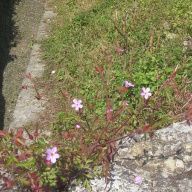

In [7]:
import IPython.display as display
display.display(display.Image(data=val_images[211]))

In [8]:
class FlowerDataset(Dataset):
    def __init__(self, id , classes , image , img_height , img_width , mean, std, is_valid):
        self.id = id
        self.classes = classes
        self.image = image
        self.is_valid = is_valid
        if self.is_valid == 1:
            self.aug = albumentations.Compose([
                
                albumentations.Resize(img_height , img_width, always_apply = True),
                
                albumentations.Normalize(mean, std, always_apply = True)
            ])
        else:
            self.aug = albumentations.Compose([
                albumentations.Resize(img_height , img_width, always_apply = True),
                
                albumentations.Normalize(mean, std, always_apply = True),
                
                albumentations.ShiftScaleRotate(shift_limit = 0.0625,
                                               scale_limit = 0.1,
                                               rotate_limit = 5,
                                               p = 0.9)
            ])
            
            
    def __len__(self):
        return len(self.id)
    
    def __getitem__(self, index):
        id = self.id[index]
        img = np.array(Image.open(io.BytesIO(self.image[index])))
        img = cv2.resize(img, dsize=(192,192), interpolation = cv2.INTER_CUBIC)
        img = self.aug(image=img)['image']
        img = np.transpose(img, (2,1,0)).astype(np.float32)
      #  img =torch.from_numpy(img).view(-1, 3, 128, 128)
        img = torch.from_numpy(img)
     #   return img , int(self.classes[index]), self.id[index]
        return img , int(self.classes[index])

In [9]:
train_dataset = FlowerDataset(id = train_ids, classes = train_class, image = train_images,
                             img_height = 192, img_width = 192,
                             mean = (0.485, 0.456, 0.406),
                             std = (0.229, 0.224, 0.225), is_valid = 0)

val_dataset = FlowerDataset(id = val_ids, classes = val_class, image = val_images,
                             img_height = 192, img_width = 192,
                             mean = (0.485, 0.456, 0.406),
                             std = (0.229, 0.224, 0.225), is_valid = 1)


In [10]:

train_dataset[1][0]

tensor([[[-1.6676, -1.7281, -1.7727,  ..., -1.2039, -1.2202, -1.2563],
         [-1.5849, -1.6458, -1.7214,  ..., -1.1327, -1.1657, -1.1972],
         [-1.4950, -1.5571, -1.6710,  ..., -1.0126, -1.0591, -1.1038],
         ...,
         [-1.6191, -1.5921, -1.5711,  ..., -1.4554, -1.4206, -1.4087],
         [-1.6301, -1.6049, -1.5970,  ..., -1.4910, -1.4697, -1.4669],
         [-1.6744, -1.6298, -1.6220,  ..., -1.5100, -1.4753, -1.4624]],

        [[-1.1357, -1.2738, -1.4244,  ..., -1.1656, -1.1864, -1.1954],
         [-0.9689, -1.1297, -1.3160,  ..., -1.0985, -1.1049, -1.1295],
         [-0.7796, -0.9439, -1.1345,  ..., -0.9712, -0.9971, -1.0378],
         ...,
         [-1.5783, -1.5507, -1.5293,  ..., -0.8151, -0.9180, -1.0362],
         [-1.5896, -1.5637, -1.5557,  ..., -0.8744, -0.9659, -1.1136],
         [-1.6348, -1.5892, -1.5812,  ..., -1.0176, -1.0692, -1.1442]],

        [[-1.6062, -1.6256, -1.6325,  ..., -1.1645, -1.1688, -1.1917],
         [-1.5310, -1.5816, -1.6070,  ..., -1

In [1]:


#idx = 219
#img = np.array(Image.open(io.BytesIO(val_images[idx])))
#print(img)
#nimg = img.numpy()
#plt.imshow(np.transpose(img))

In [11]:

batch_size = 64



train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,shuffle=True, num_workers=batch_size)



In [12]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [14]:
# Resnet 
from torchvision import transforms, models
from torchvision.models import resnet152


model = models.resnet101(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

#model.fc = torch.nn.Linear(model.fc.in_features, 2)

model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(512, 256), 
    torch.nn.ReLU(),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(256, 104), 
#    torch.nn.LogSoftmax(dim=1)
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5.0e-4)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.05)

In [15]:
from tqdm import tqdm
train_model(model, loss, optimizer, scheduler, num_epochs=4);

Epoch 0/3:


/home/bearbalalaika/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 798/798 [01:56<00:00,  6.84it/s]

train Loss: 3.9753 Acc: 0.1544



100%|██████████| 232/232 [00:34<00:00,  6.71it/s]

val Loss: 3.2616 Acc: 0.2996
Epoch 1/3:



100%|██████████| 798/798 [01:55<00:00,  6.93it/s]

train Loss: 3.4271 Acc: 0.2554



100%|██████████| 232/232 [00:35<00:00,  6.58it/s]

val Loss: 3.2153 Acc: 0.3046
Epoch 2/3:



100%|██████████| 798/798 [01:59<00:00,  6.67it/s]

train Loss: 3.4020 Acc: 0.2581



100%|██████████| 232/232 [00:36<00:00,  6.29it/s]

val Loss: 3.2224 Acc: 0.3035
Epoch 3/3:



100%|██████████| 798/798 [02:08<00:00,  6.21it/s]

train Loss: 3.4074 Acc: 0.2575



100%|██████████| 232/232 [00:37<00:00,  6.20it/s]

val Loss: 3.2182 Acc: 0.3007


In [16]:
for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=7.0e-4)

# Decay LR by a factor of 0.05 every 1 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
train_model(model, loss, optimizer, scheduler, num_epochs=10);

Epoch 0/9:


 28%|██▊       | 220/798 [01:38<04:11,  2.30it/s]

In [22]:
test_feature_description = {
    'id': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
}


In [23]:
def _parse_image_function_test(example_proto):
    return tf.io.parse_single_example(example_proto, test_feature_description)

In [24]:
test_ids = []
test_images = []
for i in test_files:
    test_image_dataset = tf.data.TFRecordDataset(i)
    
    test_image_dataset = test_image_dataset.map(_parse_image_function_test)

    ids = [str(id_features['id'].numpy())[2:-1] for id_features in test_image_dataset]
    test_ids = test_ids + ids

    images = [image_features['image'].numpy() for image_features in test_image_dataset]
    test_images = test_images + images

In [75]:
test_files = glob.glob("/home/bearbalalaika/Desktop/Kaggle/Flovers/*/test/*.tfrec")

In [71]:
test_images

[]

In [25]:
class FlowerTestDataset(Dataset):
    def __init__(self, id , image , img_height , img_width , mean, std, is_valid):
        self.id = id
        
        self.image = image
        self.is_valid = is_valid
        if self.is_valid == 1:
            self.aug = albumentations.Compose([
                
                albumentations.Resize(img_height , img_width, always_apply = True),
                
                albumentations.Normalize(mean, std, always_apply = True)
            ])
        else:
            self.aug = albumentations.Compose([
                albumentations.Resize(img_height , img_width, always_apply = True),
                
                albumentations.Normalize(mean, std, always_apply = True),
                
                albumentations.ShiftScaleRotate(shift_limit = 0.0625,
                                               scale_limit = 0.1,
                                               rotate_limit = 5,
                                               p = 0.9)
            ])
            
            
    def __len__(self):
        return len(self.id)
    
    def __getitem__(self, index):
        id = self.id[index]
        img = np.array(Image.open(io.BytesIO(self.image[index])))
        img = cv2.resize(img, dsize=(192,192), interpolation = cv2.INTER_CUBIC)
        img = self.aug(image=img)['image']
        img = np.transpose(img, (2,1,0)).astype(np.float32)
      #  img =torch.from_numpy(img).view(-1, 3, 128, 128)
        img = torch.from_numpy(img)
     
        return img , self.id[index]

In [26]:
test_dataset = FlowerTestDataset(id = test_ids, image = test_images,
                             img_height = 192, img_width = 192,
                             mean = (0.485, 0.456, 0.406),
                             std = (0.229, 0.224, 0.225), is_valid = 1)

In [27]:

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [28]:

def predict(loader, device):
    with torch.no_grad():
        torch.cuda.empty_cache()
        model.eval()
        preds = dict()
        for i, (ip, ids) in enumerate(loader):
            ip = ip.to(device)
            output = model(ip)
            _, pred = output.max(dim=1)
            for i, j in zip(ids, pred.cpu().detach()):
                preds[i] = j.item()
        return preds
    
preds = predict(test_loader, device)

In [29]:
import pandas as pd
sub_csv = pd.read_csv('/home/bearbalalaika/Desktop/Kaggle/Flovers/sample_submission.csv')
sub_csv.head()

,id,label
0,b48c962e0,0
1,a13d3dfa4,0
2,94269c190,0
3,bcb18c6e4,0
4,d15a4d94c,0


In [30]:
for key in preds.keys():
    sub_csv.loc[sub_csv['id'] == key, 'label'] = preds[key]
sub_csv.head()

,id,label
0,b48c962e0,82
1,a13d3dfa4,50
2,94269c190,73
3,bcb18c6e4,103
4,d15a4d94c,49


In [31]:
sub_csv.to_csv('submission.csv', index=False)